# IMDB Movie review Sentiment Analysis

In [228]:
# Import necessary packages
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization
from sklearn.model_selection import train_test_split

#for visualization
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from wordcloud import STOPWORDS

tf.get_logger().setLevel('ERROR')

## Load the data

In [4]:
data = pd.read_csv(r'../Data/IMDB-Dataset.csv')
data.shape

(50000, 2)

In [5]:
data.head()

review sentiment
0  One of the other reviewers has mentioned that ...  positive
1  A wonderful little production. <br /><br />The...  positive
2  I thought this was a wonderful way to spend ti...  positive
3  Basically there's a family where a little boy ...  negative
4  Petter Mattei's "Love in the Time of Money" is...  positive

In [6]:
# Check to see the validity of data
data.isnull().sum()

review       0
sentiment    0
dtype: int64

In [7]:
data.describe(include = 'all')

review sentiment
count                                               50000     50000
unique                                              49582         2
top     Loved today's show!!! It was a variety and not...  negative
freq                                                    5     25000

In [8]:
# Convert the setiment column to have 0 or 1 class values
sentiment_labels = {
    'positive':1, 
    'negative':0
}

data['sentiment'] = data['sentiment'].apply(lambda x : sentiment_labels[x])
# Output first ten rows
data.head()

review  sentiment
0  One of the other reviewers has mentioned that ...          1
1  A wonderful little production. <br /><br />The...          1
2  I thought this was a wonderful way to spend ti...          1
3  Basically there's a family where a little boy ...          0
4  Petter Mattei's "Love in the Time of Money" is...          1

## EDA

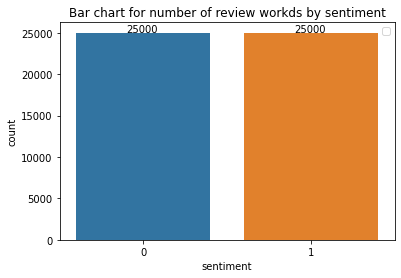

In [21]:
# Plot the distribution by sentiment type
ax = sns.countplot(x='sentiment', data= data)
plt.title('Bar chart for number of review workds by sentiment')
for p in ax.patches:
    ax.annotate('{:.0f}'.format(p.get_height()), (p.get_x()+0.3, p.get_height()+15))
    
h, l = ax.get_legend_handles_labels()
ax.legend(h, ['0 - Negative', '1 - Positive'], loc='upper right')
plt.show()

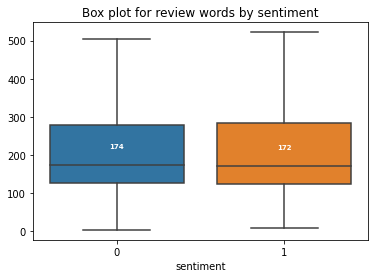

In [22]:
# Plot the review lengths to see how the distribution looks like based on review length
review_len = pd.Series([len(review.split()) for review in data['review']])

# The distribution of sentiments by review length
box_plot = sns.boxplot(x=data['sentiment'], y=review_len, showfliers=False)
plt.title('Box plot for review words by sentiment')

data2=data.copy()
data2['review_length']=data2['review'].str.split().str.len()
medians=data2.groupby(['sentiment'])['review_length'].median()
vertical_offset = data2['review_length'].median() * 0.25 # offset from median for display

for xtick in box_plot.get_xticks():
    box_plot.text(xtick,medians[xtick] + vertical_offset,medians[xtick], 
            horizontalalignment='center',size='x-small',color='w',weight='semibold')

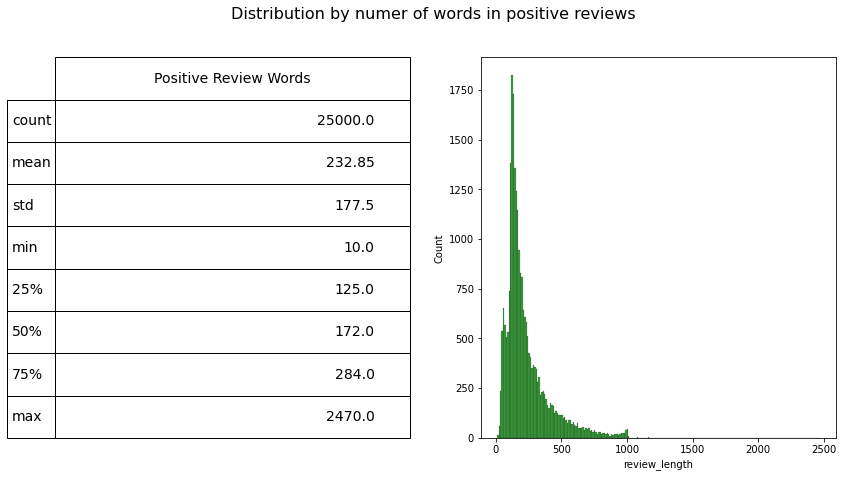

In [51]:
# Plot the distribution of reviews by length
fig = plt.figure(figsize=(14,7))
ax1 = fig.add_subplot(122)
sns.histplot(pd.Series(data2[data2['sentiment']==1]['review_length']), ax=ax1,color='green')

describe=data2[data2['sentiment']==1]['review_length'].describe().to_frame().round(2)
ax2 = fig.add_subplot(121)
ax2.axis('off')
font_size = 14
bbox = [0, 0, 1, 1]
table = ax2.table(cellText=describe.values, rowLabels=describe.index, bbox=bbox, colLabels=['Positive Review Words'])
table.set_fontsize(font_size)
fig.suptitle('Distribution by numer of words in positive reviews', fontsize=16)
plt.show()

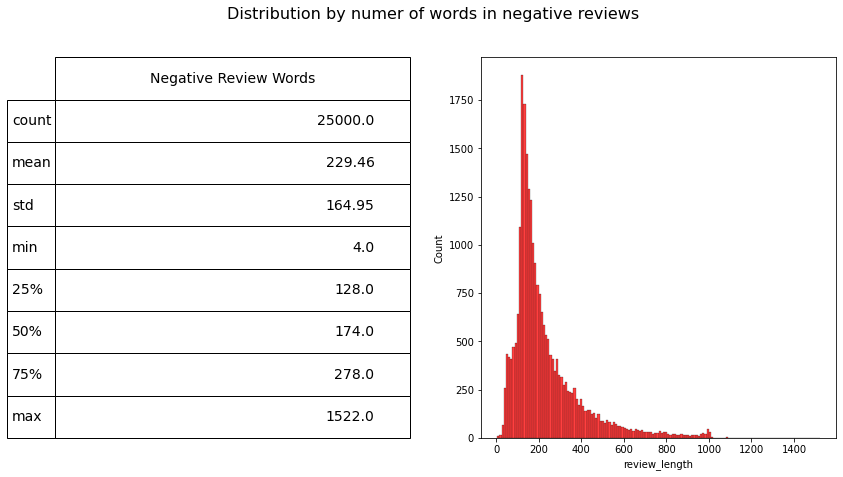

In [52]:
# Plot the distribution of reviews by length
fig = plt.figure(figsize=(14,7))
ax1 = fig.add_subplot(122)
sns.histplot(pd.Series(data2[data2['sentiment']==0]['review_length']), ax=ax1,color='red')

describe=data2[data2['sentiment']==0]['review_length'].describe().to_frame().round(2)
ax2 = fig.add_subplot(121)
ax2.axis('off')
font_size = 14
bbox = [0, 0, 1, 1]
table = ax2.table(cellText=describe.values, rowLabels=describe.index, bbox=bbox, colLabels=['Negative Review Words'])
table.set_fontsize(font_size)
fig.suptitle('Distribution by numer of words in negative reviews', fontsize=16)
plt.show()

In [125]:
#?WordCloud

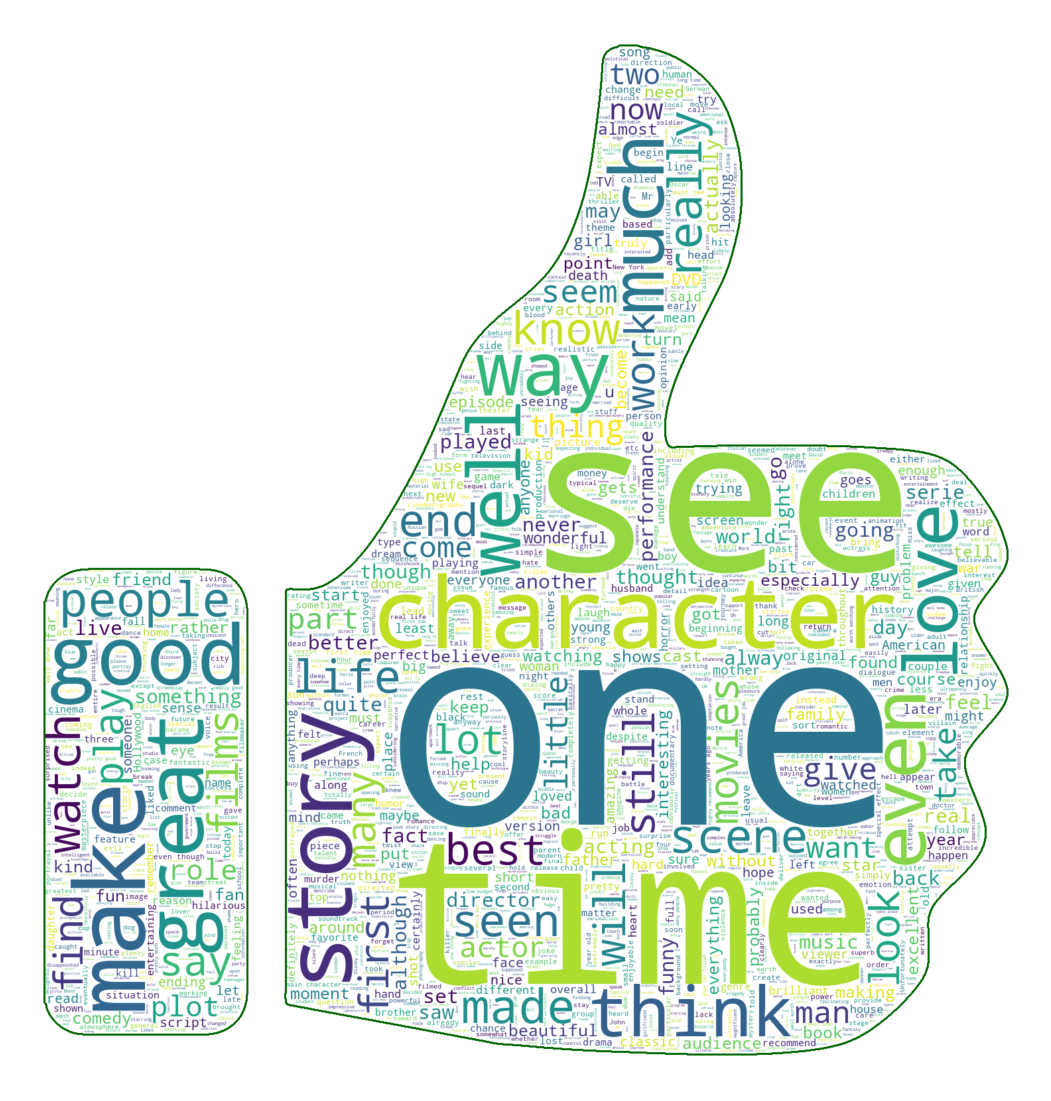

In [146]:
custom_stopwords=set(STOPWORDS)
custom_stopwords.add('br')
custom_stopwords.add('film')
custom_stopwords.add('movie')
custom_stopwords.add('show')
image_mask=np.array(Image.open(r'../Data/thumbs-up.png'))
plt.figure(figsize = (20,20))
wc = WordCloud(background_color="white", 
                mask=image_mask, 
                max_words = 2000, 
                stopwords=custom_stopwords,
                width=1600, height=800,
                contour_width=3, contour_color='darkgreen')
wc.generate(" ".join(data[data.sentiment == 1].review))
plt.imshow(wc , interpolation='bilinear')
plt.axis("off")
plt.show()

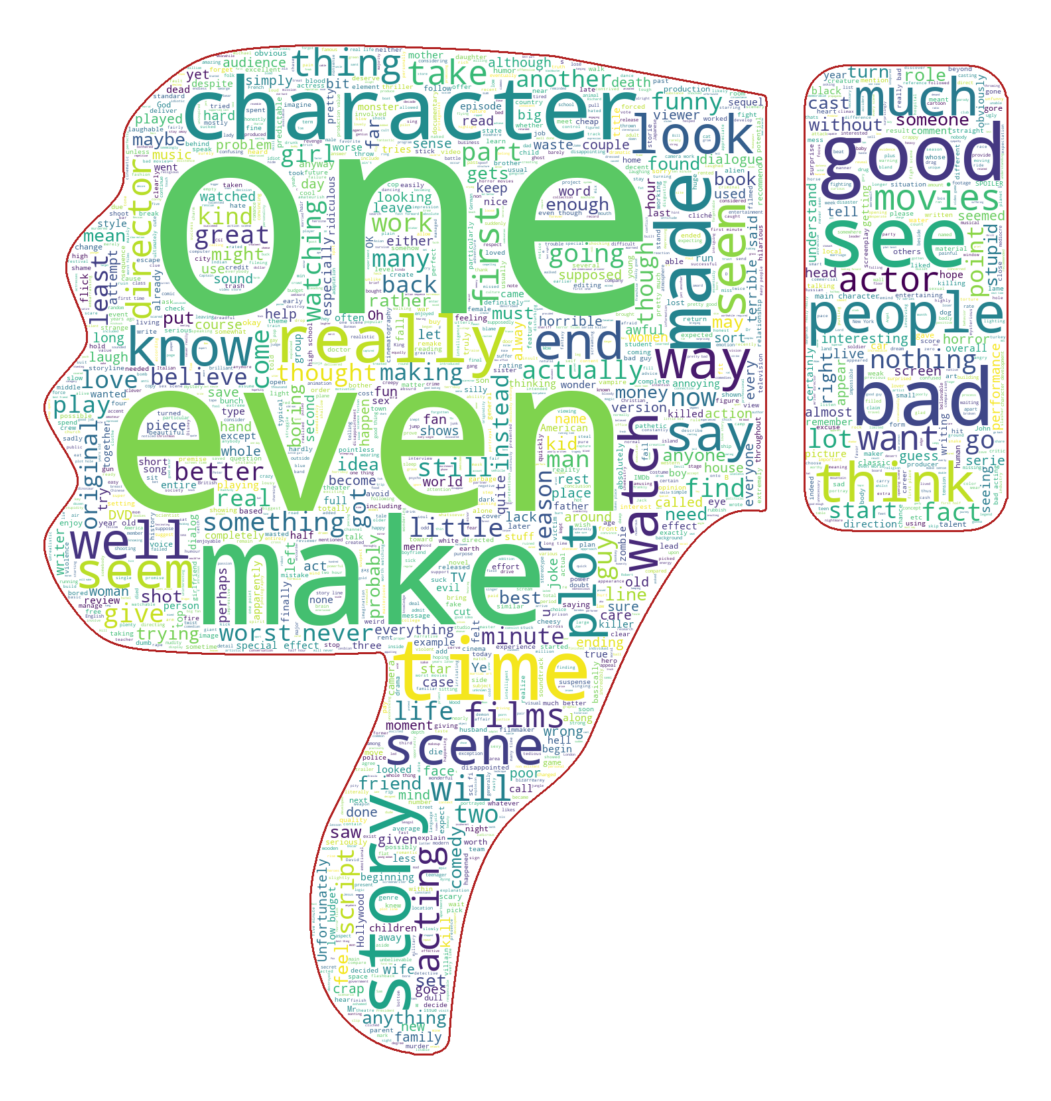

In [147]:
image_mask=np.array(Image.open(r'../Data/thumbs-down.png'))
plt.figure(figsize = (20,20))
wc = WordCloud(background_color="white", 
                mask=image_mask, 
                max_words = 2000, 
                stopwords=custom_stopwords,
                width=1600, height=800,
                contour_width=3, contour_color='firebrick')
wc.generate(" ".join(data[data.sentiment == 0].review))
plt.imshow(wc , interpolation='bilinear')
plt.axis("off")
plt.show()

## Modeling

Using BERT model from tensorflow hub for review classification model. BERT preprocessing model will be used for pre-processing the data for modeling as well.

### Define the model

In [198]:
# Define the pre-processing and the transformation encoding models to be used for the final model

BERT_PREPROCESSOR = 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'
BERT_ENCODER_MODEL = 'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1'

print(f'BERT model selected           : {BERT_PREPROCESSOR}')
print(f'Preprocess model auto-selected: {BERT_ENCODER_MODEL}')

BERT model selected           : https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3
Preprocess model auto-selected: https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1


In [199]:
# Temporary code to allow unverified ssl certificate of tensorflow hub
#import ssl
#ssl._create_default_https_context = ssl._create_unverified_context

In [203]:
## Run some samples through pre-processor that tokenizes the input text into tokenized inputs needed for transformer encoder model

# Get the pre-processing model
bert_preprocess_model = hub.KerasLayer(BERT_PREPROCESSOR)

# Sample texts
sample_texts = ['this is such an amazing movie!', 'I am a random sentence', 'young animals are cute and funny']

# Convert text into inputs needed for encoder models for example texts
tokenized_inputs = bert_preprocess_model(sample_texts)
print(f'Shape of pre-processed data output - {text_preprocessed["input_word_ids"].shape}\n')

for key in list(tokenized_inputs.keys()):
    print(f'Key - {key}:')
    print(f'\tFirst record  : {tokenized_inputs[key][0][:12]}')
    print(f'\tSecond record : {tokenized_inputs[key][1][:12]}')
    print(f'\tThird record : {tokenized_inputs[key][2][:12]}')


Shape of pre-processed data output - (3, 128)

Key - input_word_ids:
	First record  : [ 101 2023 2003 2107 2019 6429 3185  999  102    0    0    0]
	Second record : [ 101 1045 2572 1037 6721 6251  102    0    0    0    0    0]
	Third record : [  101  2402  4176  2024 10140  1998  6057   102     0     0     0     0]
Key - input_mask:
	First record  : [1 1 1 1 1 1 1 1 1 0 0 0]
	Second record : [1 1 1 1 1 1 1 0 0 0 0 0]
	Third record : [1 1 1 1 1 1 1 1 0 0 0 0]
Key - input_type_ids:
	First record  : [0 0 0 0 0 0 0 0 0 0 0 0]
	Second record : [0 0 0 0 0 0 0 0 0 0 0 0]
	Third record : [0 0 0 0 0 0 0 0 0 0 0 0]


### Output details
The result of preprocessing is a batch of fixed-length input sequences for the Transformer encoder.  

An input sequence starts with one start-of-sequence token, followed by the tokenized segments, each terminated by one end-of-segment token. Remaining positions up to seq_length, if any, are filled up with padding tokens. If an input sequence would exceed seq_length, the tokenized segments in it are truncated to prefixes of approximately equal sizes to fit exactly.  

The encoder_inputs are a dict of three int32 Tensors, all with shape \[batch_size, seq_length\], whose elements represent the batch of input sequences as follows:  
- "input_word_ids": has the token ids of the input sequences.
- "input_mask": has value 1 at the position of all input tokens present before padding and value 0 for the padding tokens.
- "input_type_ids": has the index of the input segment that gave rise to the input token at the respective position. The first input segment (index 0) includes the start-of-sequence token and its end-of-segment token. The second segment (index 1, if present) includes its end-of-segment token. Padding tokens get index 0 again.  

Retrieved from [tfhub site](https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3)

In [204]:
# Build the model using BERT pre-processor & encoding transformer model as layers.
def build_classifier_model():
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
  preprocessor = hub.KerasLayer(BERT_PREPROCESSOR, name='BERT_preprocessor')
  encoder_inputs = preprocessor(text_input)
  encoder = hub.KerasLayer(BERT_ENCODER_MODEL, trainable=True, name='BERT_encoder')
  outputs = encoder(encoder_inputs)
  net_model = outputs['pooled_output']
  net_model = tf.keras.layers.Dropout(0.1)(net_model)
  net_model = tf.keras.layers.Dense(1, activation=None, name='classifier')(net_model)
  return tf.keras.Model(text_input, net_model)

In [220]:
# Create and save model
bert_classifier_model = build_classifier_model()
bert_classifier_model.summary()
#bert_classifier_model.save("BERT_IMDB_Movie_Review")

# Use below to reload model
#bert_classifier_model=keras.models.load_model("BERT_IMDB_Movie_Review")

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
text (InputLayer)               [(None,)]            0                                            
__________________________________________________________________________________________________
BERT_preprocessor (KerasLayer)  {'input_word_ids': ( 0           text[0][0]                       
__________________________________________________________________________________________________
BERT_encoder (KerasLayer)       {'sequence_output':  28763649    BERT_preprocessor[0][0]          
                                                                 BERT_preprocessor[0][1]          
                                                                 BERT_preprocessor[0][2]          
____________________________________________________________________________________________

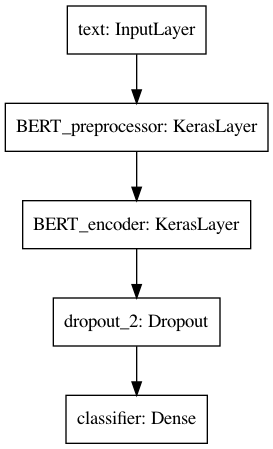

In [221]:
#import keras.utils.vis_utils
#from importlib import reload
#reload(keras.utils.vis_utils)

# Plot the model structure
keras.utils.vis_utils.plot_model(bert_classifier_model)

### Model Training

In [224]:
# Setup the attributes needed for model training
INIT_LR = 3e-5
NUM_EPOCS = 5

STEPS_PER_EPOCH = 625
NUM_TRAIN_STEPS = STEPS_PER_EPOCH * NUM_EPOCS
NUM_WARMUP_STEPS = int(0.1*NUM_TRAIN_STEPS)
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
METRICS = tf.metrics.BinaryAccuracy()
opt = optimization.create_optimizer(init_lr=INIT_LR,
                                          num_train_steps=NUM_TRAIN_STEPS,
                                          num_warmup_steps=NUM_WARMUP_STEPS,
                                          optimizer_type='adamw')

In [227]:
# Compile the model
bert_classifier_model.compile(optimizer=opt,
                         loss=loss,
                         metrics=METRICS)

In [246]:
# Build the training and testing data
X_train, X_test, y_train, y_test = train_test_split(data.review,data.sentiment, test_size=0.2, random_state=1)

X_train, X_val, y_train, y_val  = train_test_split(X_train, y_train, test_size=0.16, random_state=1) # 0.25 x 0.8 = 0.2

print('Number of reviews in the total set      : {}'.format(len(data['review'])))
print('Number of reviews in the training set   : {}'.format(len(X_train)))
print('Number of reviews in the validation set : {}'.format(len(X_val)))
print('Number of reviews in the testing set    : {}'.format(len(X_test)))

Number of reviews in the total set      : 50000
Number of reviews in the training set   : 33600
Number of reviews in the validation set : 6400
Number of reviews in the testing set    : 10000


In [249]:
# Train the model
history = bert_classifier_model.fit(X_train, y_train,
                               validation_data=(X_val, y_val),
                               epochs=NUM_EPOCS)

Epoch 1/5
1050/1050 [==============================] - 7114s 7s/step - loss: 0.4492 - binary_accuracy: 0.7693 - val_loss: 0.3427 - val_binary_accuracy: 0.8531
Epoch 2/5
1050/1050 [==============================] - 6929s 7s/step - loss: 0.3042 - binary_accuracy: 0.8672 - val_loss: 0.3336 - val_binary_accuracy: 0.8553
Epoch 3/5
1050/1050 [==============================] - 6724s 6s/step - loss: 0.2378 - binary_accuracy: 0.9007 - val_loss: 0.3465 - val_binary_accuracy: 0.8669
Epoch 4/5
1050/1050 [==============================] - 6714s 6s/step - loss: 0.2116 - binary_accuracy: 0.9121 - val_loss: 0.3465 - val_binary_accuracy: 0.8669
Epoch 5/5
1050/1050 [==============================] - 6959s 7s/step - loss: 0.2092 - binary_accuracy: 0.9151 - val_loss: 0.3465 - val_binary_accuracy: 0.8669


In [250]:
# Save model
bert_classifier_model.save("BERT_IMDB_Movie_Review_Trained")

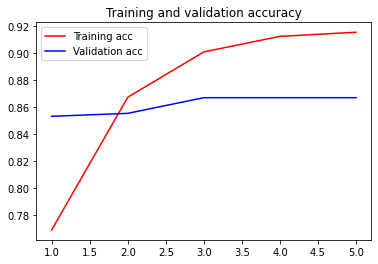

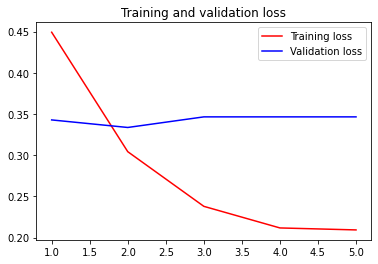

In [256]:
# Plot the model performance over time
#print(history.history)
acc = history.history['binary_accuracy']
val_acc = history.history['val_binary_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [257]:
loss, accuracy = bert_classifier_model.evaluate(X_test, y_test)

print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

313/313 [==============================] - 671s 2s/step - loss: 0.3381 - binary_accuracy: 0.8665
Loss: 0.3380799889564514
Accuracy: 0.8665000200271606


In [265]:
# Test the model with some random example reviews
examples_reviews = [
    'this is such an amazing movie!',  # this is the same sentence tried earlier
    'The movie was great!',
    'The movie was unrealistic.',
    'Casting was horrible in this movie!',
    'The movie was terrible...',
    'I would love to watch this movie again!',
    'There is nothing special about this film.'
]
results = tf.sigmoid(bert_classifier_model(tf.constant(examples_reviews)))

result_for_printing = \
    [f'input: {examples_reviews[i]:<45} ; score: {results[i][0]:.6f}'
                         for i in range(len(examples_reviews))]
print(*result_for_printing, sep='\n')

input: this is such an amazing movie!                ; score: 0.998134
input: The movie was great!                          ; score: 0.989870
input: The movie was unrealistic.                    ; score: 0.059322
input: Casting was horrible in this movie!           ; score: 0.003026
input: The movie was terrible...                     ; score: 0.002388
input: I would love to watch this movie again!       ; score: 0.976245
input: There is nothing special about this film.     ; score: 0.066461


References - I have referred to several tfhub.dev sites to gain more understanding about models and implement them. But below kaggle notebook has helped me with most of the basic functions
- https://www.kaggle.com/kritanjalijain/movie-review-sentiment-analysis-eda-bert